## Install Required Libraries

In [ ]:
pip install pandas numpy scikit-learn tensorflow matplotlib seaborn joblib

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.2-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.17.0-cp312-cp312-win_amd64.whl.metadata (34 kB)
  Using cached tensorboard_da

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os


## Load and Preprocess Data

In [ ]:
# Load dataset
df = pd.read_csv(r"C:\Users\Sariga\OneDrive\Documents\Twitter_project_folder\training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ['polarity', 'text']

In [ ]:
# Remove neutral tweets, map labels: 0 (negative), 1 (positive)
df = df[df.polarity != 2]
df['polarity'] = df['polarity'].map({0: 0, 4: 1})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#\w+", "", text)     # Remove hashtags
    text = re.sub(r"[^a-z\s]", "", text) # Remove special characters
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)

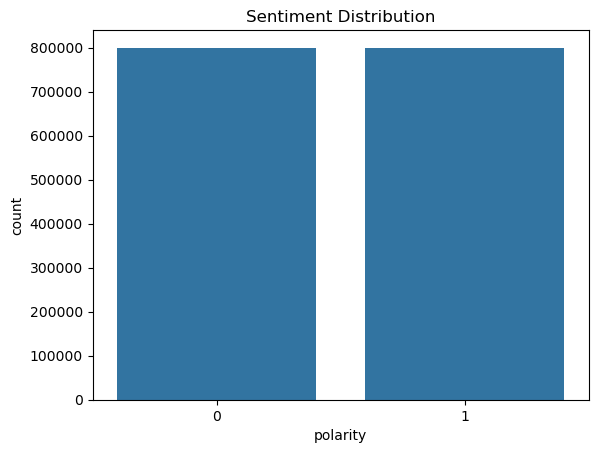

In [ ]:
# Visualize sentiment distribution
sns.countplot(x='polarity', data=df)
plt.title("Sentiment Distribution")
plt.show()

## Split Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['polarity'], test_size=0.2, random_state=42, stratify=df['polarity']
)


## Classic ML Pipeline (TF-IDF + Logistic Regression)

In [ ]:
# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Evaluate
y_pred_ml = logreg.predict(X_test_vec)
print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_ml))
print(classification_report(y_test, y_pred_ml))

=== Logistic Regression Results ===
Accuracy: 0.770271875
              precision    recall  f1-score   support

           0       0.79      0.74      0.76    160000
           1       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
logreg = LogisticRegression(max_iter=500)

# Set up hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_vec, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Use best estimator for prediction
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test_vec)

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.7707007812499999


In [ ]:
# Save model and vectorizer
joblib.dump(best_logreg, r"C:\Users\Sariga\OneDrive\Documents\Twitter_project_folder\saved_models\best_logreg_model.pkl")
joblib.dump(vectorizer, r"C:\Users\Sariga\OneDrive\Documents\Twitter_project_folder\saved_models\tfidf_vectorizer.pkl")

Current working directory: c:\Users\Sariga\AppData\Local\Programs\Microsoft VS Code


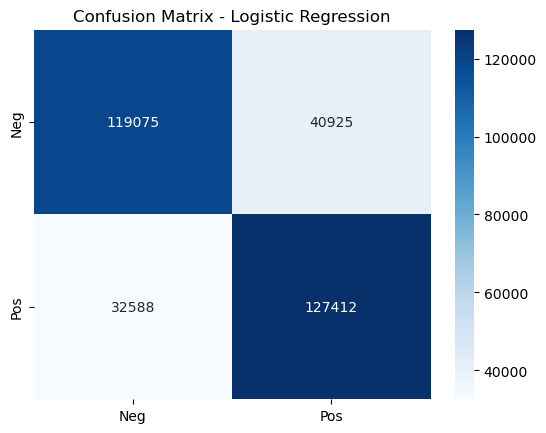

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_ml)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Deep Learning Pipeline (LSTM)

In [ ]:
MAX_VOCAB = 20000
MAX_LEN = 50

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(shape=(MAX_LEN,)),   # Explicit input length
    Embedding(MAX_VOCAB, 128), # No input_length param
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()  # Now params will be shown


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,699,905 (10.30 MB)

 Trainable params: 2,699,905 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with early stopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=1024,  # Adjust based on RAM usage; 1024 should be smooth on 16GB
    callbacks=[es],
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 560s 445ms/step - accuracy: 0.7957 - loss: 0.4417 - val_accuracy: 0.8156 - val_loss: 0.4055
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 554s 443ms/step - accuracy: 0.8212 - loss: 0.3975 - val_accuracy: 0.8204 - val_loss: 0.3949
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 553s 442ms/step - accuracy: 0.8294 - loss: 0.3815 - val_accuracy: 0.8225 - val_loss: 0.3930
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 557s 445ms/step - accuracy: 0.8360 - loss: 0.3680 - val_accuracy: 0.8234 - val_loss: 0.3946
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 548s 439ms/step - accuracy: 0.8422 - loss: 0.3558 - val_accuracy: 0.8234 - val_loss: 0.3963


In [ ]:
# Save model and tokenizer
model.save(r"C:\Users\Sariga\OneDrive\Documents\Twitter_project_folder\saved_models\lstm_sentiment_model.keras")
joblib.dump(tokenizer, r"C:\Users\Sariga\OneDrive\Documents\Twitter_project_folder\saved_models\tokenizer.pkl")

['C:\\Users\\Sariga\\OneDrive\\Documents\\Twitter_project_folder\\saved_models\\tokenizer.pkl']

LSTM Accuracy: 0.8225
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82    160000
           1       0.83      0.82      0.82    160000

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



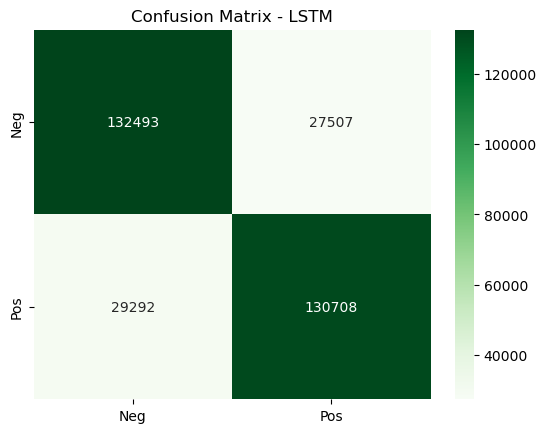

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Accuracy: {acc:.4f}")

y_pred_dl = (model.predict(X_test_pad) > 0.5).astype(int)
print(classification_report(y_test, y_pred_dl))

cm_dl = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix - LSTM")
plt.show()

## Predict Sentiment on New Tweets

In [ ]:
sample_tweets = [
    "I absolutely love this product!",
    "This is the worst thing I've ever bought.",
    "It's okay, nothing special."
]

# ML prediction
best_logreg = grid.best_estimator_
ml_preds = best_logreg.predict(vec)


# LSTM prediction
seq = tokenizer.texts_to_sequences(sample_tweets)
pad = pad_sequences(seq, maxlen=MAX_LEN)
dl_preds = (model.predict(pad) > 0.5).astype(int)

print("Logistic Regression Predictions:", ml_preds)
print("LSTM Predictions:", dl_preds.reshape(-1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Logistic Regression Predictions: [1 0 1]
LSTM Predictions: [1 0 1]
